# ReGraph tutorial (NetworkX backend)


## Part 2: Rewriting hierarchies of graph

ReGraph allows to create a hierarchies of graphs related by means of _homomorphisms_ (or _typing_). In the context of a hierarchy, if there exists a homomorphism $G \rightarrow T$, we say that graph $G$ is typed by a graph $T$. Graph hierarchy is a DAG, where nodes are graphs and edges are homomorphisms. A homomorphism  maps every node of $G$ to some node in $T$ (a type) in such a way that:
- edges are preserved
- attributes of both nodes and edges are preserved 

In [1]:
from regraph import NXGraph, NXHierarchy, Rule
from regraph import plot_graph, plot_instance, plot_rule

In [2]:
%matplotlib inline

### 1. Creating and modifying a hierarchy object

Consider the following example of a simple graph hierarchy. The two graphs $G$ and $T$ are being created and added to the heirarchy. Afterwards a typing homomorphism between $G$ and $T$ is added, so that every node of $G$ is typed by some node in $T$.

In [3]:
# Define graph G
g = NXGraph()
g.add_nodes_from(["protein", "binding", "region", "compound"])
g.add_edges_from([("region", "protein"), ("protein", "binding"), ("region", "binding"), ("compound", "binding")])

# Define graph T
t = NXGraph()
t.add_nodes_from(["action", "agent"])
t.add_edges_from([("agent", "agent"), ("agent", "action")])

In [4]:
# Create a hierarchy
simple_hierarchy = NXHierarchy()
simple_hierarchy.add_graph("G", g, {"name": "Simple protein interaction"})
simple_hierarchy.add_graph("T", t, {"name": "Agent interaction"})
simple_hierarchy.add_typing(
    "G", "T",
    {"protein": "agent",
     "region": "agent",
     "compound": "agent",
     "binding": "action",
    }
)
print(simple_hierarchy)


Graphs:

G {'name': {'Simple protein interaction'}}

T {'name': {'Agent interaction'}}

Typing homomorphisms: 
G -> T: {}

Relations:



The method `get_graph` returns the graph object corresponding to the provided graph id.

In [5]:
type(simple_hierarchy.get_graph("T"))

regraph.backends.networkx.graphs.NXGraph

The method `get_typing` returns the dictionary object corresponding to the provided hierarchy edge and representing the associated graph homomorphism.

In [6]:
simple_hierarchy.get_typing("G", "T")

{'protein': 'agent',
 'region': 'agent',
 'compound': 'agent',
 'binding': 'action'}

/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


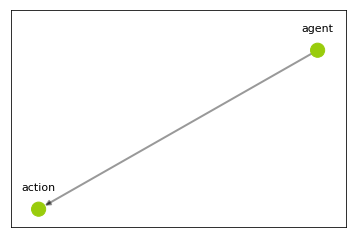

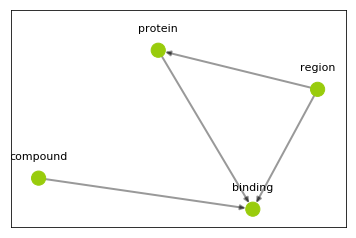

In [7]:
t_node_positions = plot_graph(simple_hierarchy.get_graph("T"))
g_node_positions = plot_graph(simple_hierarchy.get_graph("G"))

### 2. Rewriting of objects in a hierarchy

ReGraph implements the rewriting technique called `sesqui-pushout rewriting` that allows to transform graphs by applying rules through their instances (matchings). Rewriting an individual graphs in a hierarchy may require an update of other graphs and typings in this hierarchy, such updates are called _propagation_ and are distinguished into two types: _backward_ and _forward_ propagation.

_Backward propagation briefly_: 
- If some graph elements (nodes/edges or attributes) are removed from a graph in the hierarchy, then all the respective elements that are typed by them in the ancestor graphs **should** be removed.
- If a graph node is cloned, then for every instance of this node (every node that is typed by the clonned node) in the ancestor graphs we either: (a) specify to which clone it corresponds or (b) clone it.

_Forward propagation briefly_: 
- If some graph nodes are merged and these nodes are typed by different nodes in a descendant graph, the corresponding nodes in the descendant graph **should** be merged.
- If a new graph element (node/edge or attribute) is added, then for all the descendent graphs in the hierarchy we either (a) select an existing element to type the added element or (b) add a new element to type the added element.

For more details, please see [here](https://link.springer.com/chapter/10.1007/978-3-030-23611-3_9).

ReGraph allows to rewrite individual graphs situated in the hierarchy using the method `rewrite` of `NXHierarchy`. The rewriting can be done in two modes:

1. _Strict rewriting_ rewriting that does not allow propagation.

2. _Not strict rewriting_ that allows propagation.


The `rewrite` takes as the input the following parameters:

- `graph_id`, ID of the graph in the hierarchy to rewrite,
- `rule`, a rule object to apply,
- `instance`, a dictionary containing an instance of the lhs of the rule in the graph subject to rewriting, by default, tries to construct identity morphism of the nodes of the pattern,
- `p_typing`, a dictionary containing typing of graphs in the hierarchy by the interface of the rule, keys are IDs of hierarchy graphs, values are dictionaries containing the mapping of nodes from the hierarchy graphs to the inteface nodes (note that a node from a graph can be typed by a set of nodes in the interface of the rule, e.g. if we want to perform cloning of some types, etc).
- `rhs_typing`, a dictionary containing typing of the rhs by graphs of the hierarchy, keys are ids of hierarchy graphs, values are dictionaries containing the mapping of nodes from the lhs to the nodes of the typing graph given by the respective key of the value (note that a node from the rhs can be typed by a set of nodes of some graph, e.g. if we want to perform merging of some types, etc),
- `strict`, flag indicating if rewriting is strict, then any propagation is not allowed.

    


#### 2.1. Strict rewriting 

Let us create a `Rule` object containing a rule we would like to apply.

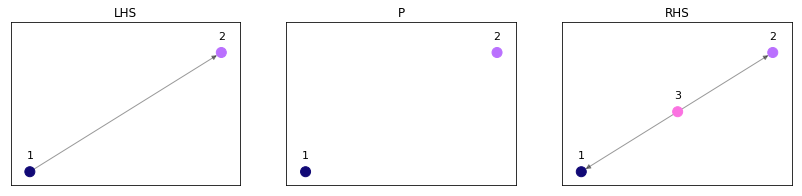

In [8]:
lhs = NXGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = NXGraph()
p.add_nodes_from([1, 2])
p.add_edges_from([])

rhs = NXGraph()
rhs.add_nodes_from([1, 2, 3])
rhs.add_edges_from([(3, 1), (3, 2)])

# By default if `p_lhs` and `p_rhs` are not provided
# to a rule, it tries to construct this homomorphisms
# automatically by matching the names. In this case we
# have defined lhs, p and rhs in such a way that that
# the names of the matching nodes correspond
rule = Rule(p, lhs, rhs)
plot_rule(rule)

The created rule removes the edge `1->2`, adds the new node `3` and two edges `3->1` and `3->2`.

Let us find instances of the created rule in the graph `G`.

Instances:  [{1: 'compound', 2: 'binding'}, {1: 'region', 2: 'binding'}, {1: 'protein', 2: 'binding'}, {1: 'region', 2: 'protein'}]


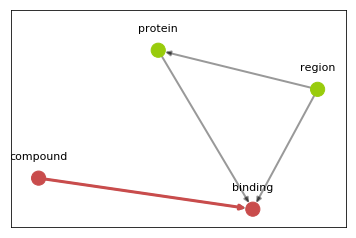

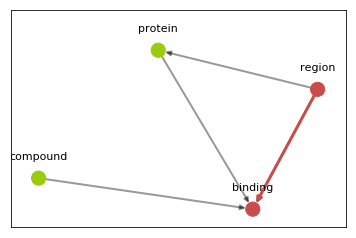

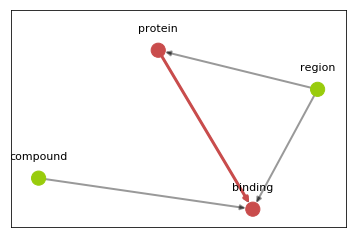

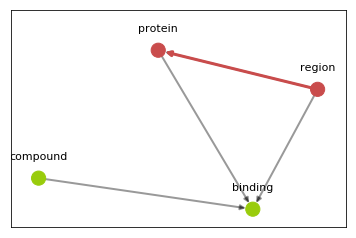

In [9]:
instances = simple_hierarchy.find_matching("G", rule.lhs)
print("Instances: ", instances)

for instance in instances:
    plot_instance(
        simple_hierarchy.get_graph("G"),
        rule.lhs,
        instance,
        parent_pos=g_node_positions) #filename=("instance_example_%d.png" % i))

Let us fixed the desired instance: we would like to remove the edge from `protein` to `binding` and add some new node connecting them.

In [10]:
instance = {
    1: "protein",
    2: "binding"
}

We try to apply the rule to the selected instance as is in the _strict_ rewriting mode.

In [11]:
try:
    rhs_instance = simple_hierarchy.rewrite("G", rule, instance, strict=True)
except Exception as e:
    print("Error message: ", e)
    print("Type: ", type(e))

Error message:  Rewriting is strict (no propagation of types is allowed), typing of the added nodes '{3}' by 'T' is required
Type:  <class 'regraph.exceptions.RewritingError'>


We have failed to rewrite `G`, because we have not specified typing for the newly added node `3`. Let us try again, but this time we will prove such typing.

In [12]:
rhs_typing = {
    "T": {3: "agent"}
}

In [13]:
rhs_instance = simple_hierarchy.rewrite(
    "G", rule, instance, rhs_typing=rhs_typing, strict=True)

Instance of the RHS in G {1: 'protein', 2: 'binding', 3: 3}


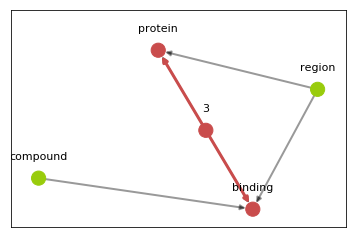

{'protein': array([-0.21919179,  0.7327296 ]),
 'binding': array([ 0.39815843, -0.6965346 ]),
 'region': array([0.82103336, 0.38117497]),
 'compound': array([-1.        , -0.41736997]),
 3: array([0.09158812, 0.01262589])}

In [14]:
print("Instance of the RHS in G", rhs_instance)
plot_instance(
    simple_hierarchy.get_graph("G"),
    rule.rhs,
    rhs_instance,
    parent_pos=g_node_positions)

We will now create a rule that applied to `T` and that clones the node `agent` into two nodes.

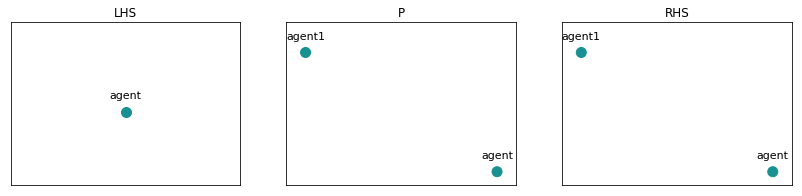

In [15]:
lhs = NXGraph()
lhs.add_nodes_from(["agent"])

rule = Rule.from_transform(lhs)
_, rhs_clone = rule.inject_clone_node("agent")
plot_rule(rule)

In [16]:
instance = {
    "agent": "agent"
}

We try to apply the created rule to the graph `T` in the strict mode.

In [17]:
try:
    rhs_instance = simple_hierarchy.rewrite("T", rule, instance, strict=True)
except Exception as e:
    print("Error message: ", e)
    print("Type: ", type(e))

Error message:  Rewriting is strict (no propagation of clones is allowed), the cloned node 'agent' in 'T' has instances '['protein', 'region', 'compound', 3]' in 'G' and their typing by P is not specified
Type:  <class 'regraph.exceptions.RewritingError'>


We have failed to rewrite `T`, because we have not specified typing for instances of `agent` in $p$. Let us try again, but this time we will prove such typing.

In [18]:
p_typing = {
    "G": {
        'protein': 'agent',
        'region': 'agent',
        'compound': rhs_clone, 
        3: 'agent'
    }
}

In [19]:
rhs_instance = simple_hierarchy.rewrite("T", rule, instance, p_typing=p_typing, strict=True)

Instance of the RHS in G {'agent': 'agent', 'agent1': 'agent1'}


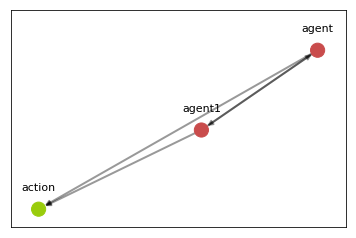

{'action': array([-0.12484052, -1.        ]),
 'agent': array([0.12484052, 1.        ]),
 'agent1': array([ 0.02085518, -0.00388293])}

In [20]:
print("Instance of the RHS in G", rhs_instance)
plot_instance(
    simple_hierarchy.get_graph("T"),
    rule.rhs,
    rhs_instance,
    parent_pos=t_node_positions)

Let us relabel nodes in `T`.

In [21]:
simple_hierarchy.relabel_graph_node('T', rhs_instance['agent'], 'organic_agent')
simple_hierarchy.relabel_graph_node('T', rhs_instance[rhs_clone], 'non_organic_agent')

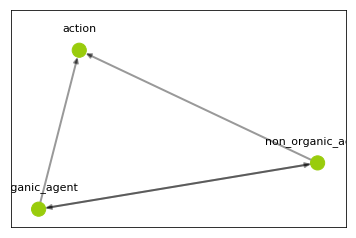

{'protein': 'organic_agent', 'binding': 'action', 'region': 'organic_agent', 'compound': 'non_organic_agent', 3: 'organic_agent'}


In [22]:
plot_graph(simple_hierarchy.get_graph('T'))
print(simple_hierarchy.get_typing("G", "T"))

#### 2.2. Rewriting and propagation

To illustrate rewriting with propagation, let us consider a slighlty more sophisticated hierarchy.

In [23]:
hierarchy = NXHierarchy()

colors = NXGraph()
colors.add_nodes_from([
        "green", "red"
    ])
colors.add_edges_from([
        ("red", "green"),
        ("red", "red"),
        ("green", "green")
    ])
hierarchy.add_graph("colors", colors)

shapes = NXGraph()
shapes.add_nodes_from(["circle", "square"])
shapes.add_edges_from([
        ("circle", "square"),
        ("square", "circle"),
        ("circle", "circle")
    ])
hierarchy.add_graph("shapes", shapes)

quality = NXGraph()
quality.add_nodes_from(["good", "bad"])
quality.add_edges_from([
        ("bad", "bad"),
        ("bad", "good"),
        ("good", "good")
    ])
hierarchy.add_graph("quality", quality)

g1 = NXGraph()
g1.add_nodes_from([
    "red_circle",
    "red_square",
])
g1.add_edges_from([
    ("red_circle", "red_square"),
    ("red_circle", "red_circle"),
    ("red_square", "red_circle")
])
g1_colors = {
    "red_circle": "red",
    "red_square": "red",
}
g1_shapes = {
    "red_circle": "circle",
    "red_square": "square",
}

hierarchy.add_graph("g1", g1)
hierarchy.add_typing("g1", "colors", g1_colors)
hierarchy.add_typing("g1", "shapes", g1_shapes)

g2 = NXGraph()
g2.add_nodes_from([
    "good_circle",
    "good_square",
    "bad_circle",
])
g2.add_edges_from([
    ("good_circle", "good_square"),
    ("good_square", "good_circle"),
    ("bad_circle", "good_circle"),
    ("bad_circle", "bad_circle"),
])
g2_shapes = {
    "good_circle": "circle",
    "good_square": "square",
    "bad_circle": "circle"
}
g2_quality = {
    "good_circle": "good",
    "good_square": "good",
    "bad_circle": "bad",
}

hierarchy.add_graph("g2", g2)
hierarchy.add_typing("g2", "shapes", g2_shapes)
hierarchy.add_typing("g2", "quality", g2_quality)

g3 = NXGraph()
g3.add_nodes_from([
    "good_red_circle",
    "bad_red_circle",
    "good_red_square",
])
g3.add_edges_from([
    ("bad_red_circle", "good_red_circle"),
    ("good_red_square", "good_red_circle"),
    ("good_red_circle", "good_red_square")
])

g3_g1 = {
    "good_red_circle": "red_circle",
    "bad_red_circle": "red_circle",
    "good_red_square": "red_square"
}

g3_g2 = {
    "good_red_circle": "good_circle",
    "bad_red_circle": "bad_circle",
    "good_red_square": "good_square",
}

hierarchy.add_graph("g3", g3)
hierarchy.add_typing("g3", "g1", g3_g1)
hierarchy.add_typing("g3", "g2", g3_g2)

Graph  colors


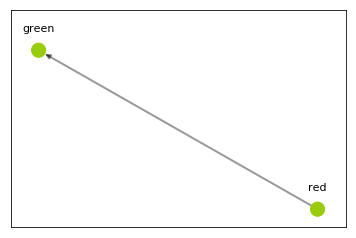

Graph  shapes


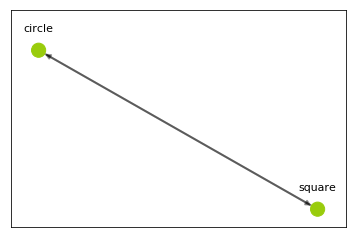

Graph  quality


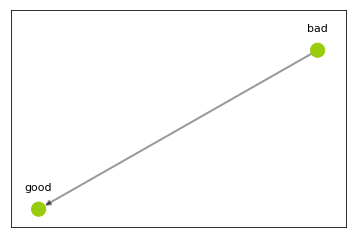

Graph  g1


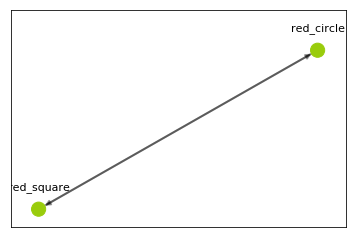

Graph  g2


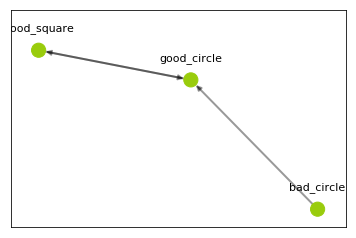

Graph  g3


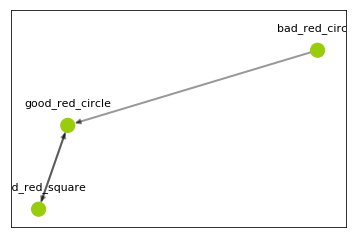

In [24]:
for graph in hierarchy.graphs():
    print("Graph ", graph)
    plot_graph(hierarchy.get_graph(graph))

In [25]:
print(hierarchy)


Graphs:

colors {}

shapes {}

quality {}

g1 {}

g2 {}

g3 {}

Typing homomorphisms: 
g1 -> colors: {}
g1 -> shapes: {}
g2 -> shapes: {}
g2 -> quality: {}
g3 -> g1: {}
g3 -> g2: {}

Relations:



Some of the graphs in the hierarchy are now typed by multiple graphs, which is reflected in the types of nodes, as in the example below:

In [26]:
print("Node types in G3:\n")
for node in hierarchy.get_graph("g3").nodes():
    print(node, hierarchy.node_type("g3", node))

Node types in G3:

good_red_circle {'g1': 'red_circle', 'g2': 'good_circle'}
bad_red_circle {'g1': 'red_circle', 'g2': 'bad_circle'}
good_red_square {'g1': 'red_square', 'g2': 'good_square'}


#### NB: Rules as nodes of a hierarchy

Having constructed a sophisticated rewriting rule typed by some nodes in the hierarchy one may want to store this rule and to be able to propagate any changes that happen in the hierarchy to the rule as well.  

ReGraph's `NXHierarchy` allows to add graph rewriting rules as nodes in the hierarchy. Rules in the hierarchy can be typed by graphs, but rule nodes are not allowed to have incoming edges, i.e. nothing can be typed by a rule.

In the example below, a rule is added to the previously constructed hierarchy and typed by graphs `g1` and `g2`:

In [27]:
lhs = NXGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = NXGraph()
p.add_nodes_from([1, 11, 2])
p.add_edges_from([(1, 2)])

rhs = NXGraph.copy(p)
rhs.add_nodes_from([3])

p_lhs = {1: 1, 11: 1, 2: 2}
p_rhs = {1: 1, 11: 11, 2: 2}

r1 = Rule(p, lhs, rhs, p_lhs, p_rhs)
hierarchy.add_rule("r1", r1, {"desc": "Rule 1: typed by two graphs"})

lhs_typing1 = {1: "red_circle", 2: "red_square"}
rhs_typing1 = {3: "red_circle"}

lhs_typing2 = {1: "good_circle", 2: "good_square"}
rhs_typing2 = {3: "bad_circle"}

hierarchy.add_rule_typing("r1", "g1", lhs_typing1, rhs_typing1)
hierarchy.add_rule_typing("r1", "g2", lhs_typing2, rhs_typing2)

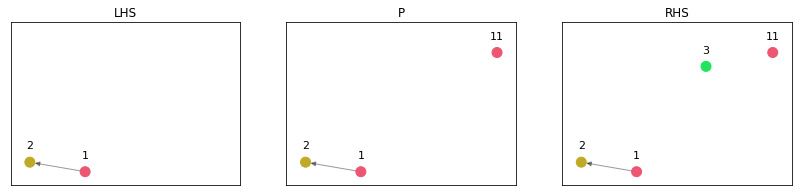

In [28]:
plot_rule(hierarchy.get_rule('r1'))

In [29]:
g1_lhs_typing, g1_rhs_typing = hierarchy.get_typing('r1', 'g1')
g2_lhs_typing, g2_rhs_typing = hierarchy.get_typing('r1', 'g2')

print("Typing of R1 by G1: ")
print("\tLHS", g1_lhs_typing)
print("\tP (is implicit)")
print("\tRHS", g1_rhs_typing)
print("Typing of R1 by G2: ")
print("\tLHS", g2_lhs_typing)
print("\tP (is implicit)")
print("\tRHS", g2_rhs_typing)

Typing of R1 by G1: 
	LHS {1: 'red_circle', 2: 'red_square'}
	P (is implicit)
	RHS {3: 'red_circle', 1: 'red_circle', 11: 'red_circle', 2: 'red_square'}
Typing of R1 by G2: 
	LHS {1: 'good_circle', 2: 'good_square'}
	P (is implicit)
	RHS {3: 'bad_circle', 1: 'good_circle', 11: 'good_circle', 2: 'good_square'}


#### 2.3. Rewriting and propagation

We now show how graph rewriting can be performed in such an hierarchy. In the previous example we perfromed strict rewriting in a hierarchy, where no propagation was performed.

The following example illustrates how the ReGraph propagates the changes made by rewriting on any level to all the graphs (as well as the rules) typed by the one target of rewriting.

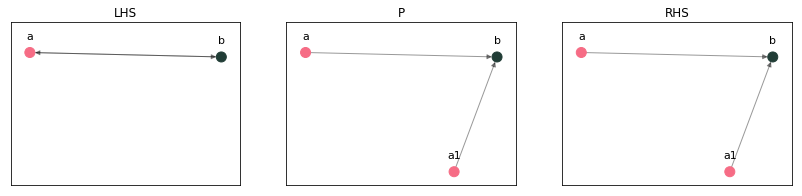

In [30]:
lhs = NXGraph()
lhs.add_nodes_from(["a", "b"])
lhs.add_edges_from([
        ("a", "b"),
        ("b", "a")
    ])
p = NXGraph()
p.add_nodes_from(["a", "a1", "b"])
p.add_edges_from([
        ("a", "b"),
        ("a1", "b")
    ])
rhs = NXGraph.copy(p)

rule = Rule(
    p, lhs, rhs,
    {"a": "a", "a1": "a", "b": "b"},
    {"a": "a", "a1": "a1", "b": "b"},
)
plot_rule(rule)

We have created a rule that clones the node `a` and reconnects the edges between `a` and `b`.

Instances:
{'b': 'square', 'a': 'circle'}


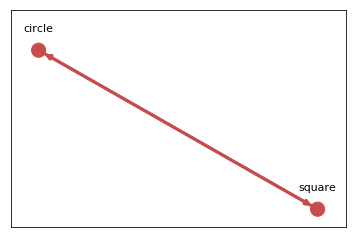

{'a': 'square', 'b': 'circle'}


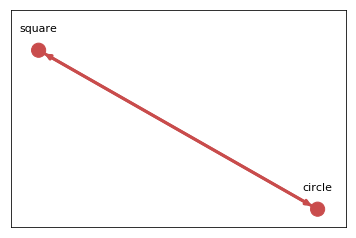

In [31]:
instances = hierarchy.find_matching("shapes", lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(hierarchy.get_graph("shapes"), rule.lhs, instance)

We rewrite the graph `shapes` with the fixed instances (so, the node `circle` is cloned).

In [32]:
rhs_instances = hierarchy.rewrite("shapes", rule, {"a": "circle", "b": "square"})

Observe the following plots, the cloning of circle was propagated to all the ancestors of `shapes`, because we didn't specify how to retype intances of `circle` for these ancestors using the `p_typing` parameter. This is an example of previously mentioned _backward propagation_.

Graph  colors


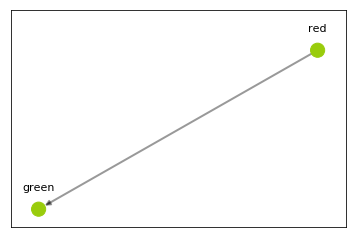

Graph  shapes


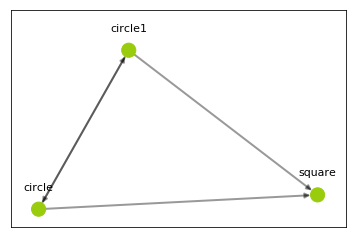

Graph  quality


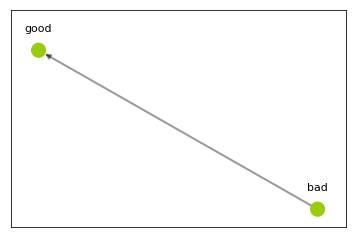

Graph  g1


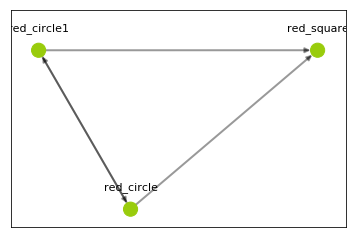

Graph  g2


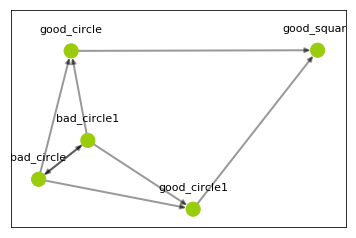

Graph  g3


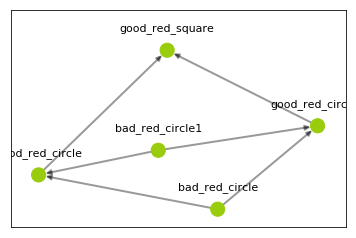

In [33]:
for graph in hierarchy.graphs():
    print("Graph ", graph)
    plot_graph(hierarchy.get_graph(graph))

Even the rule `r1` was affected as the result of propagation, all its circle nodes were cloned.

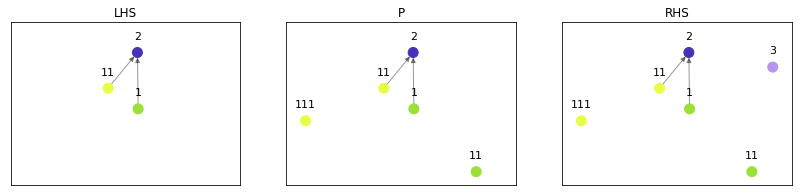

In [34]:
plot_rule(hierarchy.get_rule('r1'))

Let us now consider a small example of _forward propagation_. We will create a rule that performs some additions and merges of nodes.

In [35]:
pattern = NXGraph()
pattern.add_nodes_from(["a", "b"])

rule = Rule.from_transform(pattern)
rhs_node = rule.inject_merge_nodes(["a", "b"])
rule.inject_add_node("c")
rule.inject_add_edge("c", rhs_node)

In [36]:
instance = {
    "a": "good_circle",
    "b": "bad_circle",
}

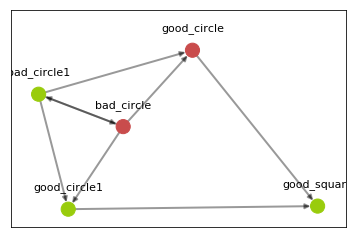

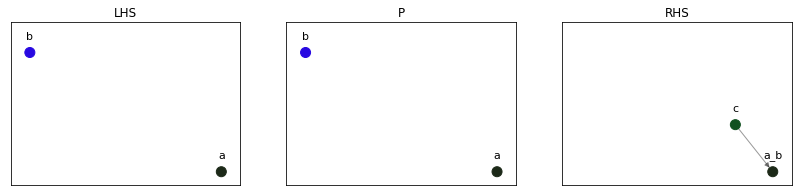

In [37]:
old_position = plot_instance(hierarchy.get_graph("g2"), rule.lhs, instance)
plot_rule(rule)

Application of this rule will merge nodes `bad_circle` and `good_circle` in the graph `g2`. It with then add a new node and connect it with an edge to the merged node. Let us specify some typings of the new node in the RHS: we will set the new node to be typed as `circle` in the graph `shapes`.

In [38]:
rhs_typing = {
    "shapes": {
        "c": "circle"
    }
}

In [39]:
rhs_instance = hierarchy.rewrite("g2", rule, instance, rhs_typing=rhs_typing)

Observe the following graphs, as the resule of forward propagation nodes `good` and `bad` were merged in the graph `qualities`. In addition, a new node typing the node `c` in the rule was added to the graph `qualities`.

Graph  colors


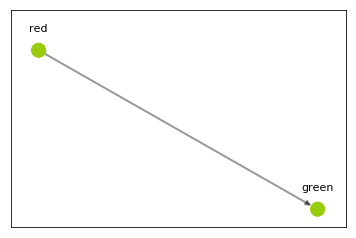

Graph  shapes


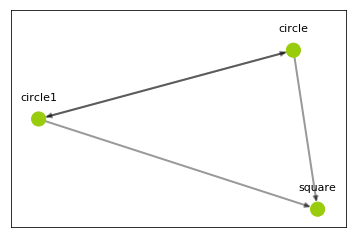

Graph  quality


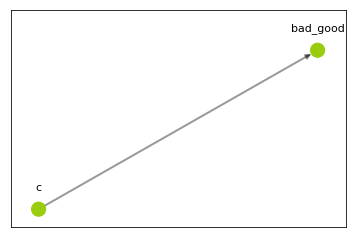

Graph  g1


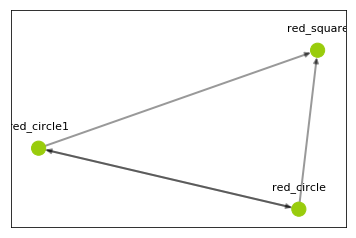

Graph  g2


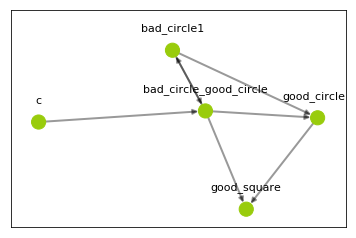

Graph  g3


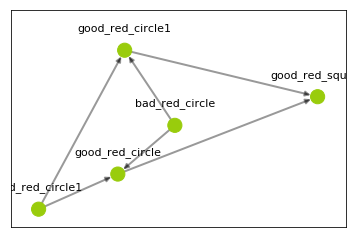

In [40]:
for graph in hierarchy.graphs():
    print("Graph ", graph)
    plot_graph(hierarchy.get_graph(graph))

### 3. Creating and modifying a hierarchy object

Because NetworkX graphs are in-memory objects, they are destroyed as soon as the Python application is no longer running. ReGraph provides some utils for serialization of `NXHierarchy` objects and implements the following methods for loading and exporting your hierarchy in JSON-format:

- `NXHierarchy.to_json` creates a json representations of the hierarchy;

- `NXHierarchy.from_json` loads an hierarchy from json representation (returns new `Hierarchy` object); 
- `NXHierarchy.export` exports the hierarchy to a file (json format);
- `NXHierarchy.load` loads an hierarchy from a .json file (returns new object as well).

In [41]:
hierarchy_json = hierarchy.to_json()

In [42]:
import json
print(json.dumps(hierarchy_json, indent="  "))

{
  "graphs": [
    {
      "id": "colors",
      "graph": {
        "edges": [
          {
            "from": "green",
            "to": "green",
            "attrs": {}
          },
          {
            "from": "red",
            "to": "green",
            "attrs": {}
          },
          {
            "from": "red",
            "to": "red",
            "attrs": {}
          }
        ],
        "nodes": [
          {
            "id": "green",
            "attrs": {}
          },
          {
            "id": "red",
            "attrs": {}
          }
        ]
      },
      "attrs": {}
    },
    {
      "id": "shapes",
      "graph": {
        "edges": [
          {
            "from": "circle",
            "to": "square",
            "attrs": {}
          },
          {
            "from": "circle",
            "to": "circle",
            "attrs": {}
          },
          {
            "from": "circle",
            "to": "circle1",
            "attrs": {}
          },
   

In [43]:
new_hierarchy = NXHierarchy.from_json(hierarchy_json)

InvalidHomomorphism: Invalid homomorphism: Mapping is not covering all the nodes of source graph! domain: {'good_square', 'bad_circle1', 'good_circle1', 'c', 'bad_circle_good_circle'}, domain of definition: {'bad_circle_good_circle', 'c'}

In [ ]:
new_hierarchy == hierarchy